# Cost saving optimisation: A worked example for a water distribution network 

Cost minimisation is **always** important to the funders and managers of infrastructure assets. However, the number of option permutations that need to be considered when making design, planning or operational decisions can quickly become enormous, making an optimal combination very hard to identify. Population based or biologially inspired algorithms are one class of optimisation techniques that can quickly converge on globally optimal (or close to optimal) solutions, even with complex, non-differentiable cost functions with numerous options or input parameters. This makes them tremendously useful, powerful and scalable techniques for attacking many cost saving exercises.

The example below demonstrates how to minimise the build cost of a water distribution network by selecting the cheapest set of pipe diameters that:

1. creates a hydraulically sound network (as validated by an [epanet model](http://www.epa.gov/water-research/epanet))
2. satisfy the pressure requirements of each demand node. 

The code and data can be [downloaded here](https://gist.github.com/selwyn-mccracken/0fabaa715d7ee24772af/archive/dea2ad9257f51bee21505df91e1554848f2c03a5.zip) and I encourage others to recycle and experiment with it. The full analysis uses less than 100 lines of python code, including comments, which hopefully shows how easy it is to deploy these techniques in practice.  

*NB: This report has been created in a [jupyter notebook](http://jupyter.org/) which allows executable code to be embedded within the document text. That is, the document is a self-contained report that can be shared and run on your local machine which facilitates fully reproducible analysis, renders nicely on sites like github, and can be easily converted into a range of report formats inclusing interactive slides.*

## The Two Loop water network 

To keep things simple, we'll focus on the small Two Loop Network (TLN) benchmark in [epanet format](http://www.epa.gov/water-research/epanet) from [here]( http://emps.exeter.ac.uk/engineering/research/cws/resources/benchmarks/design-resiliance-pareto-fronts/small-problems/
), which also provides the following description, table and architecture diagram:

> *`"Two loop network (TLN) consists of one reservoir, six demand nodes and eight pipes organised in two loops. The reservoir has a constant head fixed at 210 m. As a hypothetical network, all pipes have the same length (1000 m) and the Hazen-Williams coefficient of 130. The pressure is set to be at least 30.0 m at all demand nodes. Table TLN.1 shows commercially available diameters and the corresponding unit costs (1 in.=0.0254 m). Figure TLN.1 depicts the layout of TLN."`*

With these available pipe dimensions, the minimum pipeline cost for the total network is [known to be $419,000 (Dong et al. 2012)](http://link.springer.com/article/10.1631%2Fjzus.A1200072).

##### Table TLN.1 Diameter options and associated unit costs of TLN
![Pipe diameter cost table](http://emps.exeter.ac.uk/media/universityofexeter/emps/research/cws/downloads/pareto/TLN_T1.png)

##### Figure TLN.1 Architecture of TLN
![Network architecture](http://emps.exeter.ac.uk/media/universityofexeter/emps/research/cws/downloads/pareto/TLN.png)


Even with this small network, a brute force approach of checking every possibility to find the best answer is not desirable, as the 14 avaiable pipe types and 8 pipe sections that need to be sized means there are 14^8 (i.e. 1,475,789,056) different combinations that would need tested!!! Real networks are obviously far larger with many more pipes, constraints and configuration options which quickly make them impossible to evaluate with brute force techniques. 

## Differential Evolution

Many global optimisation techniques have been [biologically-inspired](https://en.wikipedia.org/wiki/Bio-inspired_computing) including: 

- Genetic algorithms
- Differential evolution
- Particle swarm optimisation
- Ant colony optimisation
- Neural networks
- Artificial immune systems
- Cellular automata

Most of these techniques operate similarly to one another by progressing towards a global minimum (or maximum) through a stochastic process that mimics natural evolution.  That is, an initial set of candidate inputs/options are successively randomised/bred/perturbed/blended/mutated, and if they produce a solution that is better than the existing one, then most of the new population 'survives' into the next round of breeding.  This process is repeated until the algorithm 'converges' on a solution,  meaning that no better result could be found within a defined period time or some other stopping criterion.     

The Differential Evolution (DE) algorithm of [Storn and Price (1997)](http://www1.icsi.berkeley.edu/~storn/code.html) operates in this manner, and has been a popular technique for cost optimisation tasks for water distribution networks (see [Vasan and Simonovic 2010](http://ascelibrary.org/doi/10.1061/%28ASCE%290733-9496%282010%29136%3A2%28279%29), [Dong et al. 2012](http://link.springer.com/article/10.1631%2Fjzus.A1200072), [Mansouri et al. 2015](http://dx.doi.org/10.4236/jwarp.2015.79059). There are several free DE implementations available, including for the [R](https://cran.r-project.org/web/packages/DEoptim/index.html) and [python](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.differential_evolution.html) programming languages which I make heavy use of in my day to day work. The example below is written in python. 


## Outline of python code 

There are four steps in the optimisation:
1. Load the initial network layout and configuration from the input file in epanet format
2. Write a total pipe cost function that the DE algorithm will evaluate at each iteration of its minimisation search. To drive the algorithm away from poor solutions, the total cost returned for an iteration is heavily penalised if the network is found to be:
    - hydraulically infeasible (according to epanet) 
    - does not meet the pressure demands across all nodes 
3. Run the Differential Evolution algorithm
4. Present and check the solution


### 1. Initial configuration

The [epanettools library](https://pypi.python.org/pypi/EPANETTOOLS) is used to load, manipulate and run epanet models in RAM, which allows much faster testing of model configurations than the alternative of writing models to disk and running epanent from the shell/command line. 

If you have python installed, the library can be added from the command line using: 
>`pip install epanettools` 

Please [contact me](mailto:selwyn.b.mccracken@mwhglobal.com?subject=Optimisation help) if you need help installing either python or epanettools.


In [1]:
import warnings
warnings.filterwarnings('ignore') #suppress deprecation warnings
from epanettools import epanet2 as et
from scipy.optimize import differential_evolution
from math import pi
import pandas as pd
 #use seaborn to plot results and set plot configs
import seaborn as sns
import matplotlib.pyplot as plt

#load the Two Loop Network
tln = et.ENopen('TLN.inp','tmp.rpt','') 

#retrieve the cost of each pipe type
pipe_costs = pd.read_csv('two_loop_pipe_costs.csv')

#get the number of pipes and nodes from the 
ret,npipes=et.ENgetcount(et.EN_LINKCOUNT) 
ret,nnodes=et.ENgetcount(et.EN_NODECOUNT) 

#specify the pressure constraint for each demand node
REQUIRED_PRESSURE = 30 

### 2. Total pipe cost function 

Here we define the total pipeline cost that gets calculated for each iteration of the DE algorithm. As discussed above, poor solutions (i.e. hydraulically infeasible and deficient pressure) are heavily penalised. 

The input into the function (i.e. `x`) is an array of 8 elements that contains the proposed pipe **type** for each of the 8 pipe sections in the TLN model, with values ranging from type 0 through to 13 reflecting the 14 available size options (counting in python always starts from zero). Pipe type 0 is the smallest with a 25.4mm(1 inch) diameter up to pipe type 13 which has a 609.6mm(24in) diameter.   

Note that `x` does **not** contain the raw diameters of the pipes, as this would waste lots of search cycles examining the empty spaces between the available pipe dimension which would then need to be penalised in the cost function. 


In [2]:
def total_pipeline_cost(x):
    """
    x is an array of proposed pipe type indexes in the pipe_costs table.
    However because the DE optimization works with floating point values, 
    we have to round to indices to integers to retrive the costs - i.e. can't have a row 1.5   
    """
    x_rnd = [round(xi,0) for xi in x] #round type index to integer
    diams = list(pipe_costs.loc[x_rnd,'diameter_mm']) #fetch the actual diameters of these pipe type stored in the costs table 
    cost = sum(pipe_costs.loc[x_rnd,'cost_per_m'] * 1000) #calculate the total unpenalised cost
    
    #update the network model with the proposed pipe diameters  
    for ix in range(npipes):
        ret = et.ENsetlinkvalue(ix+1, et.EN_DIAMETER,diams[ix])
    
    ##check the network is hydraulically valid according to epanet
    solution_code  = et.ENsolveH()
    
    #retrieve the demand node pressures where demand is > 0 - i.e. ignore the reservoir node
    demand_node_pressures = [et.ENgetnodevalue(i+1, et.EN_PRESSURE )[1] 
                             for i in range(nnodes) 
                                 if et.ENgetnodevalue(i+1, et.EN_DEMAND )[1] > 0 
                            ]
    #check the pressure status of each demand node
    above_pressure = [p > REQUIRED_PRESSURE for p in demand_node_pressures]
    try:
        pressure_deficit = above_pressure.index(False) > -1
    except ValueError:
        pressure_deficit = False #presure is good at all nodes
    
    if solution_code == 0: #i.e. hydraulically feasible
        if pressure_deficit == False:
            return cost #no need for a penalty to be added, as hydraulically feasible and no presseure deficits
        else:
            return cost + 4000000 #there is at least one pressure deficit, so increase cost by $4m   
    else:
        #not hydraulically feasible so apply a large penalty $40m        
        return cost + 40000000

## 3. Running the DE optimisation algorithm
Here is where the magic happens. The `differential_evolution()` function is called with the `total_pipeline_cost()` function defined above, along with some tuning parameters that don't need to be explained at the moment. So we can plot the progress of the algorithm once it is finished, the `trackcost()` callback is used to store the intermediate solutions from each iteration.    

In [3]:
#specify the range of possible values for each pipe section
#in this case there are 14 different pipe types, so the range is set from 0 to 13 because because python indices start from zero
bounds = [[0,13] for b in range(npipes)]

#define callback function and array to track the intermediate solutions
iteration_cost_value = []

def trackcost(xk,convergence):
    x_rnd = [round(xi,0) for xi in xk]
    diams = list(pipe_costs.loc[x_rnd,'diameter_mm'])
    total_cost = sum(pipe_costs.loc[x_rnd,'cost_per_m'] * 1000)
    iteration_cost_value.append(total_cost)
    
# Call the DE algorithm with our cost function 
mincost_res = differential_evolution(
    total_pipeline_cost, #use our cost function defined above
    seed=1234, #set the random number generator at a fixe point for reproducibility
    #specify callback to track solution progress 
    callback = trackcost,
    strategy = 'best1bin', 
    popsize = 50,
    mutation = (.4,.8),
    recombination = .2,
    disp=False,
    bounds=bounds,
    maxiter=100 
)
    


## 4. Solution and validity checks 

The DE function above takes 91 iterations and less than a minute to find the best known solution of $419,000 (see the chart below) . This is ridiculously better than the ~1.5 billion iterations that a brute force approach would require. 

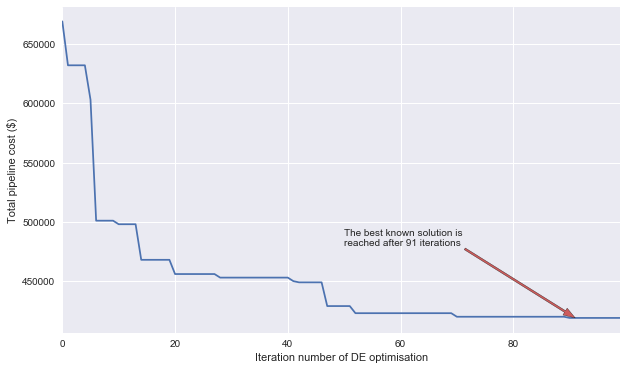

In [4]:
#plot solution progress by iteration
%matplotlib inline
plt.figure(figsize=(10, 6))
sns.tsplot(data=iteration_cost_value,)
sns.axlabel('Iteration number of DE optimisation','Total pipeline cost ($)')
plt.annotate('The best known solution is\nreached after 91 iterations', xy=(91, 419000), xytext=(50, 480000),
             arrowprops=dict(facecolor='indianred',  headwidth =8,width=2))


#### Doublecheck solution is hydraulically correct and retrieve the final set of pipe diameters.

In [5]:
#confirm currrent configuration of the network is hydraulically correct
et.ENsolveH() == 0 # a return code of zero indicates the network is feasible 


True

In [6]:
#show the table of pipe dimensions and associated costs
final_diameters = pipe_costs.loc[[round(x) for x in mincost_res.x],['diameter_mm','cost_per_m']]
final_diameters.columns.name = 'pipe type'
final_diameters

pipe type,diameter_mm,cost_per_m
10.0,457.2,130
6.0,254.0,32
9.0,406.4,90
3.0,101.6,11
9.0,406.4,90
6.0,254.0,32
6.0,254.0,32
0.0,25.4,2


In [7]:
#doublecheck the final pipeline cost = 419,000
sum(final_diameters['cost_per_m']) * 1000

419000

## Summary

Differential evolution is a powerful and relatively straightforward technique for minimising costs or any other numeric outcome of interest. The example provided only manipulates pipe diameters, but could readily be expanded to any water network configuration that can be defined in an epanet model, such as the location and sizing of pumps and pressure reducing valves, new pipeline routes or connections. If desired, OPEX or TOTEX could be the value minimised by incorporating power and maintenance costs into the model.  

The usefulness of DE optimisation clearly extends beyond water networks, and it has been used across a wide array of applications including [large scale stock portfolio optimisation](https://cran.r-project.org/web/packages/DEoptim/vignettes/DEoptimPortfolioOptimization.pdf), [facility layouts](http://dx.doi.org/10.1109/ROBIO.2013.6739725) and [electromagnetic antenna design](https://dx.doi.org/10.1109%2FMAP.2011.5773566).

For all you BIM junkies out there, the same approach could conceivably be used to improve building designs so that energy/TOTEX costs are minimised by driving [EnergyPlus models](https://energyplus.net/) with the [eppy python library](https://github.com/santoshphilip/eppy), a topic that I might address in a later post. 

If you'd like to try DE optimisation or any similar technique on your project, [please get in touch with me](mailto:selwyn.b.mccracken@mwhglobal.com?subject=Optimisation help).


## References
Ardia, D., Boudt, K., Carl, P., Mullen, K.M., Peterson, B.G., 2011. Differential Evolution with DEoptim: An Application to Non-Convex Portfolio Optimization. The R Journal 3, 27–34.

Dong, X., Liu, S., Tao, T., Li, S., Xin, K., 2012. A comparative study of differential evolution and genetic algorithms for optimizing the design of water distribution systems. Journal of Zhejiang University SCIENCE A 13, 674–686. doi:10.1631/jzus.A1200072

Mansouri, R., Torabi, H., Hoseini, M., Morshedzadeh, H., 2015. Optimization of the Water Distribution Networks with Differential Evolution (DE) and Mixed Integer Linear Programming (MILP). Journal of Water Resource and Protection 07, 715–729. doi:10.4236/jwarp.2015.79059

Rocca, P., Oliveri, G., Massa, A., 2011. Differential Evolution as Applied to Electromagnetics. IEEE Antennas and Propagation Magazine 53, 38–49. doi:10.1109/MAP.2011.5773566

Storn, R., Price, K., n.d. Differential Evolution – A Simple and Efficient Heuristic for global Optimization over Continuous Spaces. Journal of Global Optimization 11, 341–359. doi:10.1023/A:1008202821328

Tao, J., Wang, P., Qiao, H., Tang, Z., 2013. Facility layouts based on differential evolution algorithm. IEEE, pp. 1778–1783. doi:10.1109/ROBIO.2013.6739725

Vasan, A., Simonovic, S.P., 2010. Optimization of Water Distribution Network Design Using Differential Evolution. Journal of Water Resources Planning and Management 136, 279–287. doi:10.1061/(ASCE)0733-9496(2010)136:2(279)
